In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier     
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings                                          
import pickle


In [3]:
df = pd.read_csv("C:/Users/argup/Downloads/PS_20174392719_1491204439457_log.csv/PS_20174392719_1491204439457_log.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
df.drop(['isFlaggedFraud'], axis = 1, inplace = True )
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [7]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1


In [8]:
plt.style.use('ggplot') 
warnings.filterwarnings('ignore')

In [9]:
df.corr(numeric_only=True)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


<Axes: >

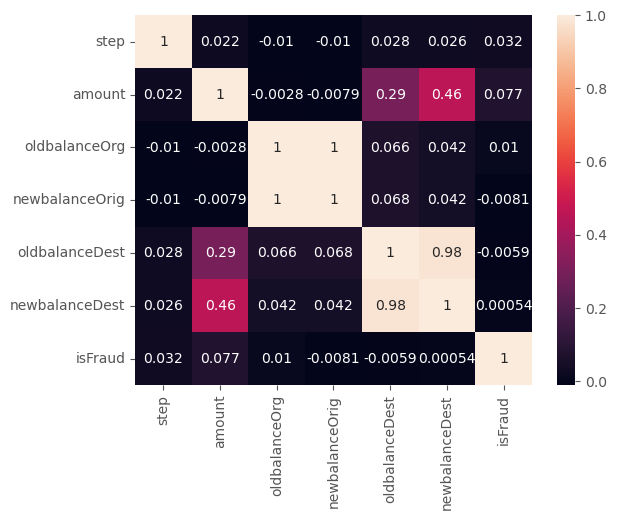

In [10]:
sns.heatmap(df.corr(numeric_only=True),annot = True)

In [11]:
#UNIVARIATE ANALYSIS

<Axes: xlabel='step', ylabel='Count'>

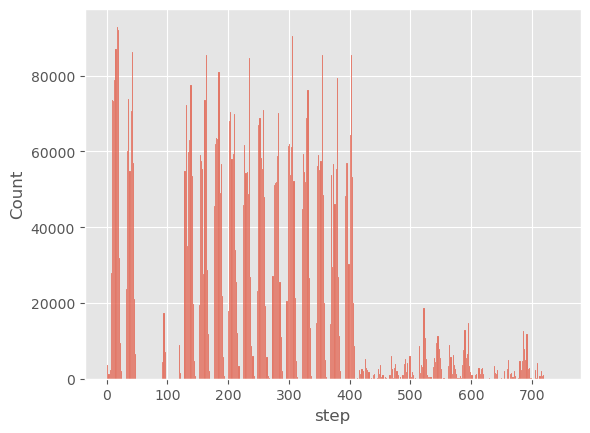

In [12]:
sns.histplot(data= df, x = 'step')

<Axes: xlabel='step'>

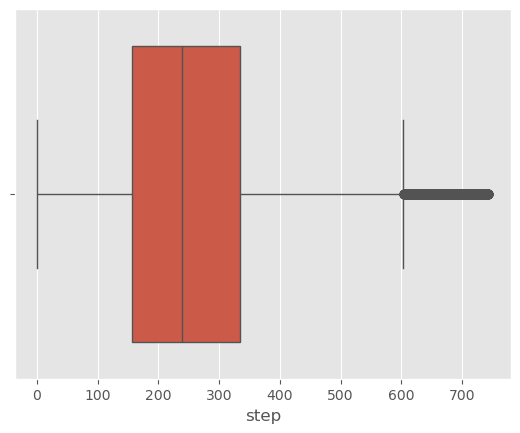

In [13]:
sns.boxplot(data = df, x='step')

<Axes: xlabel='type', ylabel='count'>

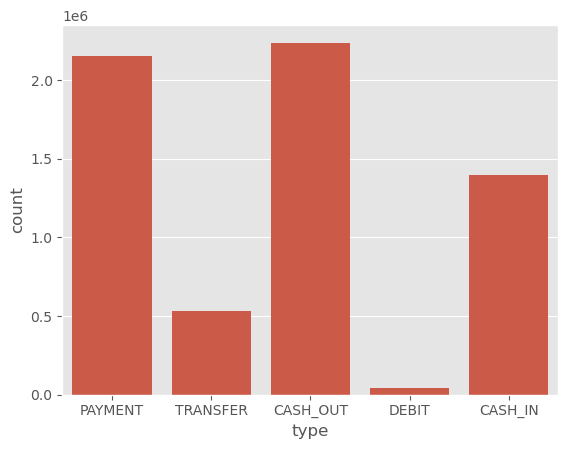

In [14]:
sns.countplot(data = df , x = 'type' )

<Axes: xlabel='amount', ylabel='Count'>

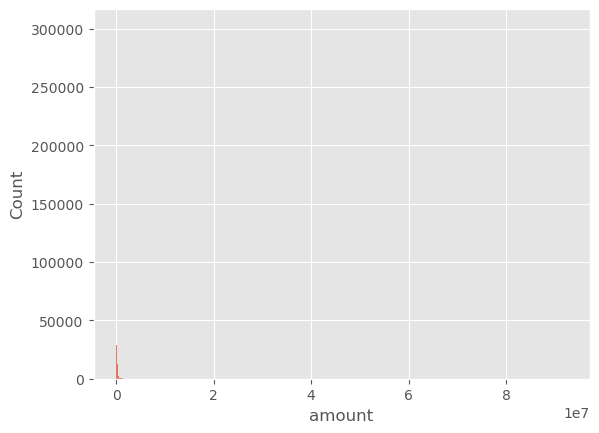

In [15]:
sns.histplot(data = df, x ='amount')

<Axes: xlabel='amount'>

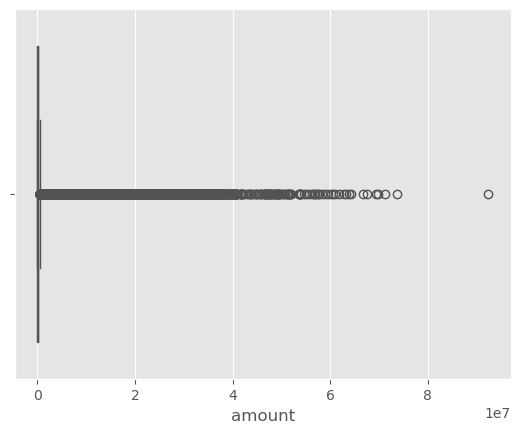

In [16]:
sns.boxplot(data = df, x = 'amount')

<Axes: xlabel='oldbalanceOrg', ylabel='Count'>

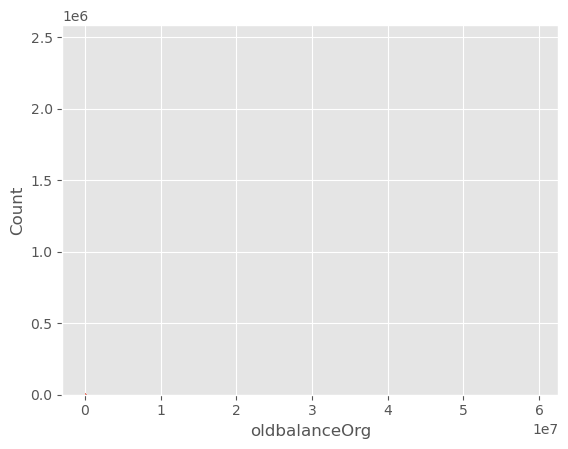

In [17]:
sns.histplot(data = df, x = 'oldbalanceOrg')

In [18]:
df['nameDest'].value_counts()

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: count, Length: 2722362, dtype: int64

<Axes: xlabel='oldbalanceOrg'>

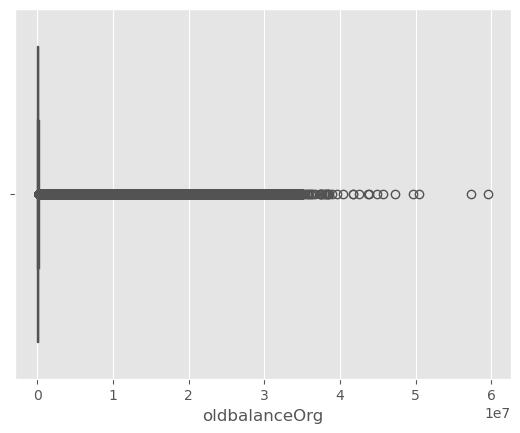

In [19]:
sns.boxplot(data = df, x = 'oldbalanceOrg')

<Axes: xlabel='newbalanceDest'>

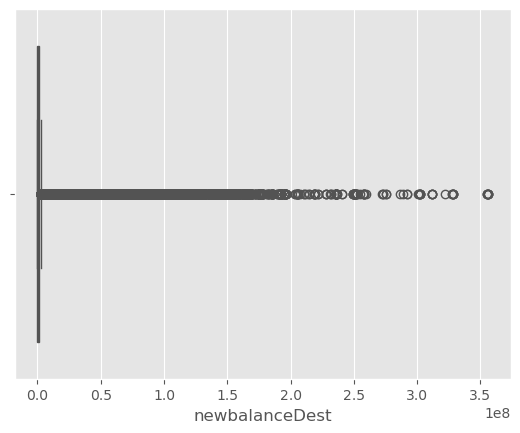

In [20]:
sns.boxplot(data = df, x = 'newbalanceDest')

<Axes: xlabel='isFraud', ylabel='count'>

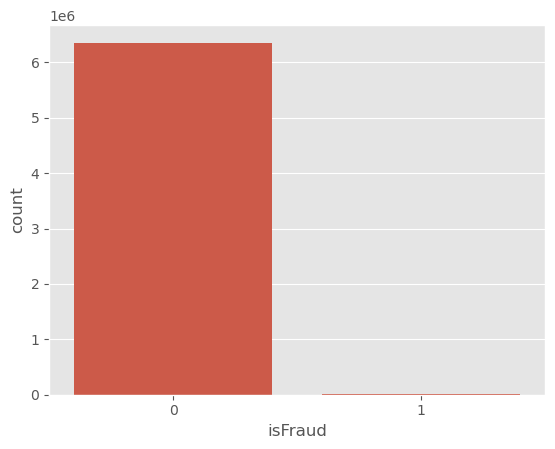

In [21]:
sns.countplot(data = df, x = 'isFraud')

In [22]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [23]:
df['isFraud'] = df['isFraud'].astype(str)
df.loc[df['isFraud'] == '0', 'isFraud'] = 'is not Fraud'
df.loc[df['isFraud'] == '1', 'isFraud'] = 'is Fraud'


In [24]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,is not Fraud
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,is not Fraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,is Fraud
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,is Fraud
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,is not Fraud
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,is Fraud
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,is Fraud
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,is Fraud
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,is Fraud


In [25]:
#Bivaiate Analysis

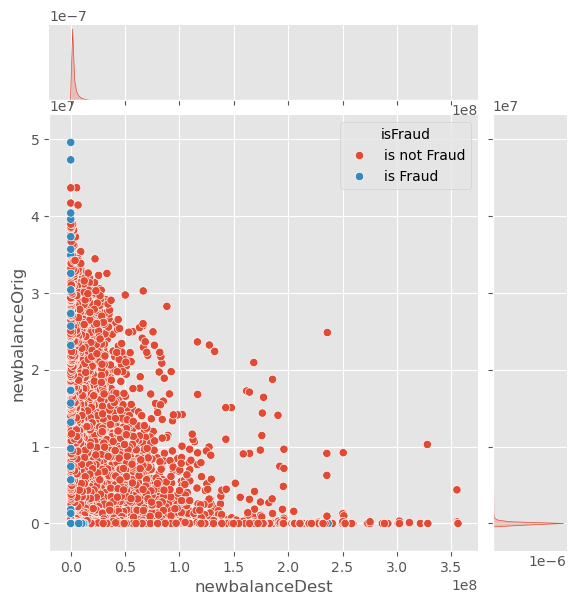

In [26]:
sns.jointplot(data = df, x='newbalanceDest', y='newbalanceOrig', hue='isFraud')

<Axes: xlabel='type', ylabel='count'>

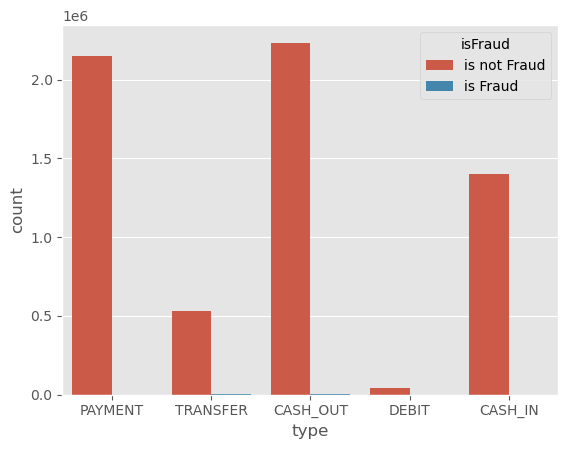

In [27]:
sns.countplot(data = df,x='type', hue ='isFraud' )

<Axes: xlabel='isFraud', ylabel='step'>

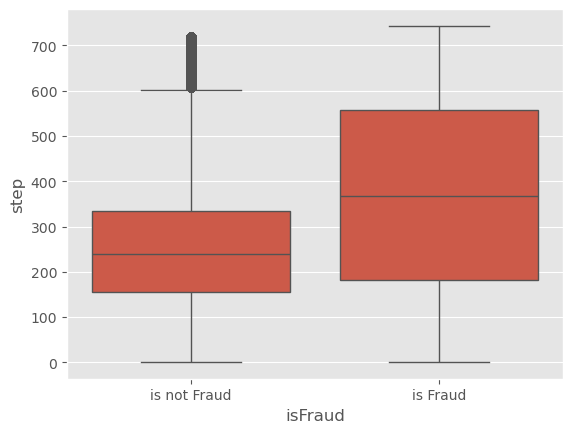

In [28]:
sns.boxplot(data = df, x= 'isFraud', y ='step')

<Axes: xlabel='isFraud', ylabel='amount'>

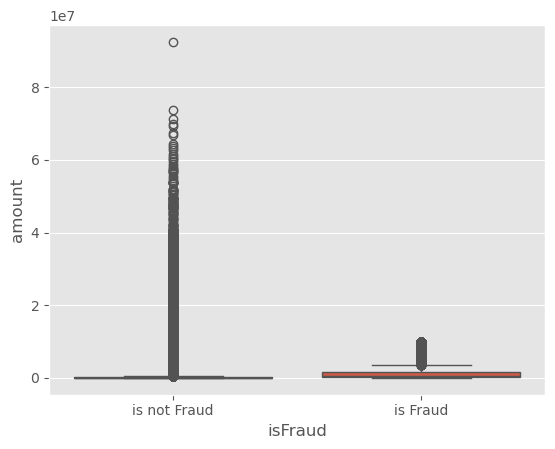

In [29]:
sns.boxplot(data = df, x='isFraud', y= 'amount')

<Axes: xlabel='isFraud', ylabel='oldbalanceOrg'>

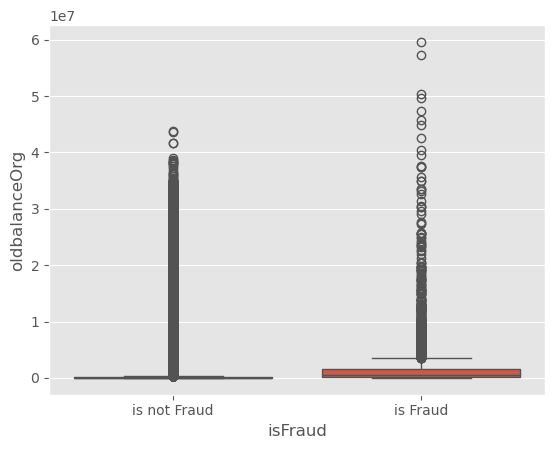

In [30]:
sns.boxplot(data = df, x='isFraud', y= 'oldbalanceOrg')

<Axes: xlabel='isFraud', ylabel='newbalanceOrig'>

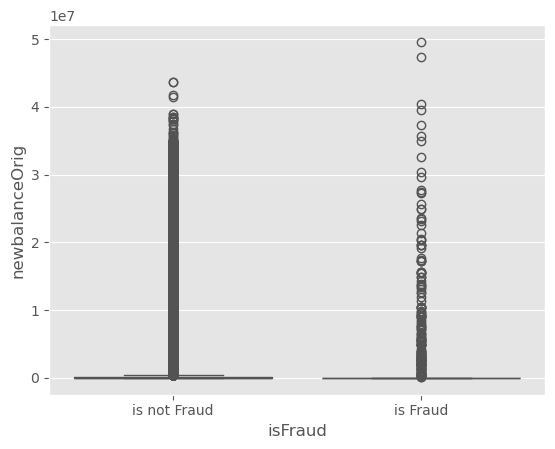

In [31]:
sns.boxplot(data = df, x = 'isFraud', y= 'newbalanceOrig')

<Axes: xlabel='isFraud', ylabel='oldbalanceDest'>

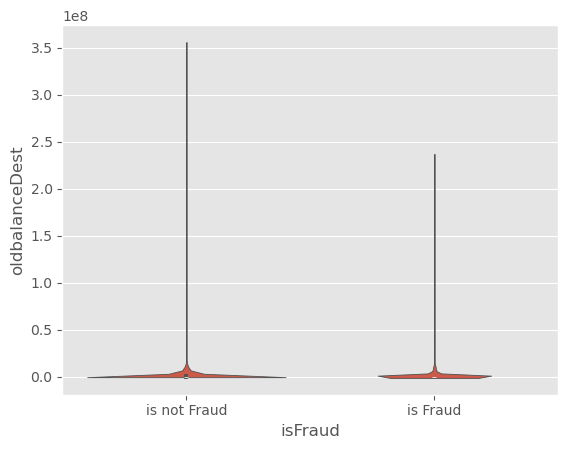

In [32]:
sns.violinplot(data = df, x = 'isFraud', y = 'oldbalanceDest' )

<Axes: xlabel='isFraud', ylabel='oldbalanceDest'>

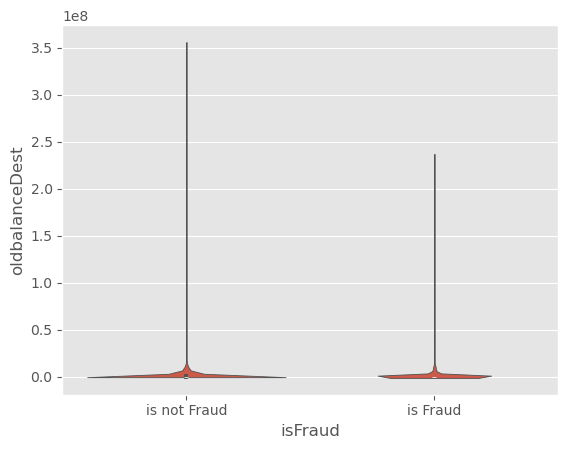

In [33]:
sns.violinplot(data = df, x = 'isFraud', y = 'oldbalanceDest')

In [34]:
#desdcriptive Analysis

In [35]:
df.describe(include = 'all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,2
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,is not Fraud
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,6354407
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,NaN
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,NaN
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,NaN
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,NaN


In [36]:
#Data Preprocessing

In [37]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [38]:
df.info

<bound method DataFrame.info of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
0             160296.36  M1979787155            0.00            0.00   
1              1938

<Axes: ylabel='amount'>

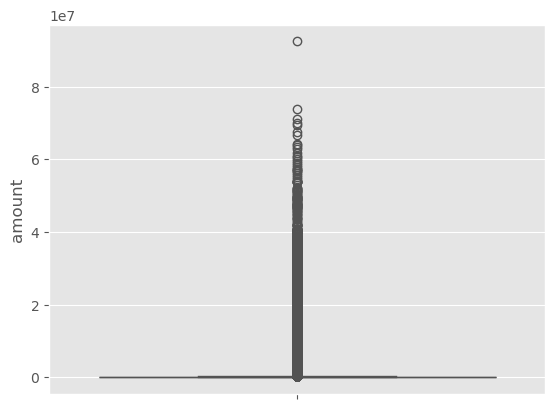

In [39]:
sns.boxplot(df['amount'])

In [40]:
from scipy import stats
print(stats.mode(df['amount']))
print(np.mean(df['amount']))

ModeResult(mode=10000000.0, count=3207)
179861.90354913071


In [41]:
q1 = np.quantile(df['amount'], 0.25)
q3 = np.quantile(df['amount'], 0.75)

IQR = q3-q1

upper_bound = q3 + (1.5 * IQR)
lower_bound = q1 - (1.5 * IQR)

print('q1: ', q1)
print('q3: ', q3)
print('IQR: ', IQR)
print('Upper Bound: ', upper_bound)
print('Lower Bound: ', lower_bound)
print('Skewed data: ', len(df[df['amount']>upper_bound]))
print('skewed data: ', len(df[df['amount']<lower_bound]))

q1:  13389.57
q3:  208721.4775
IQR:  195331.9075
Upper Bound:  501719.33875
Lower Bound:  -279608.29125
Skewed data:  338078
skewed data:  0


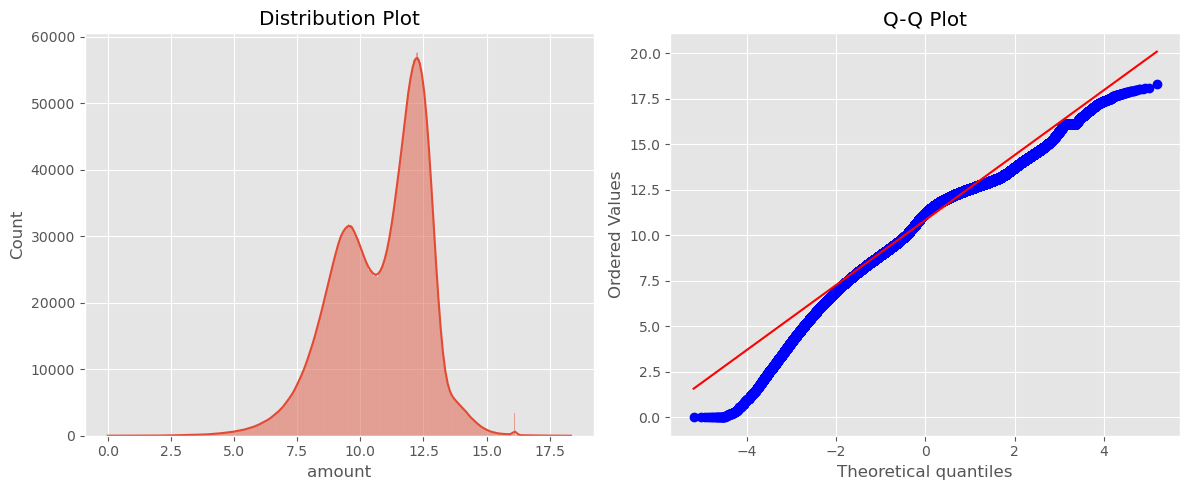

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def transformationPlot(feature):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(feature, kde=True)
    plt.title("Distribution Plot")
    
    plt.subplot(1, 2, 2)
    stats.probplot(feature, dist="norm", plot=plt)
    plt.title("Q-Q Plot")
    
    plt.tight_layout()
    plt.show()

amount = df['amount']
amount_logged = np.log1p(amount)  

transformationPlot(amount_logged)




df['amount'] = np.log(df['amount'])

In [44]:
#object Data Labelencoding

In [45]:
from sklearn.preprocessing import LabelEncoder
la = LabelEncoder()
df['type'] = la.fit_transform(df['type'])

In [46]:
df['type'].value_counts()

type
1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: count, dtype: int64

In [47]:
x = df.drop('isFraud', axis = 1)
y = df['isFraud']
x

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00
...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13
6362616,743,4,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00
6362617,743,1,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11
6362618,743,4,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00


In [48]:
y

0          is not Fraud
1          is not Fraud
2              is Fraud
3              is Fraud
4          is not Fraud
               ...     
6362615        is Fraud
6362616        is Fraud
6362617        is Fraud
6362618        is Fraud
6362619        is Fraud
Name: isFraud, Length: 6362620, dtype: object

In [49]:
#Spliting Data into Train and Test

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state = 0, test_size = 0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5090096, 9)
(1272524, 9)
(5090096,)
(1272524,)


In [51]:
#RandomForestClassifier Model

In [52]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x['nameOrig'] = le.fit_transform(x['nameOrig'])
x['nameDest'] = le.fit_transform(x['nameDest'])
rfc = RandomForestClassifier()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
rfc.fit(x_train, y_train)


RandomForestClassifier()

In [53]:
# 1. Random Forest Classifier

In [54]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
    
# Predict on test data
y_test_predict1 = rfc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict1)
print("Test Accuracy", test_accuracy)

# Predict on train data
y_train_predict1 = rfc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict1)
print("Train Accuracy",train_accuracy)

# Confusion Matrix
pd.crosstab(y_test, y_test_predict1)

# Classification Report
print("Classification Report", classification_report(y_test, y_test_predict1))

Test Accuracy 0.9997092392756443
Train Accuracy 0.9999998035400511
Classification Report               precision    recall  f1-score   support

    is Fraud       0.98      0.79      0.88      1641
is not Fraud       1.00      1.00      1.00   1270883

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



In [55]:
#2. Decision Tree CLassifer 

In [56]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

y_test_predict2 = dtc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict2)
print("Test Accuracy", test_accuracy)

y_train_predict2 = dtc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict2)
print("Train Accuracy",train_accuracy)
pd.crosstab(y_test, y_test_predict2)

print("Classification Report",classification_report(y_test, y_test_predict2))

Test Accuracy 0.9996707331256621
Train Accuracy 1.0
Classification Report               precision    recall  f1-score   support

    is Fraud       0.88      0.87      0.87      1641
is not Fraud       1.00      1.00      1.00   1270883

    accuracy                           1.00   1272524
   macro avg       0.94      0.93      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



In [57]:
#3. ExtraTrees Classifier

In [58]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(x_train, y_train)

y_test_predict3 = etc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict3)
print("Test Accuracy", test_accuracy)

y_train_predict3 = etc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict3)
print("Train Accuracy",train_accuracy)

pd.crosstab(y_test, y_test_predict3)

print("Classification Report",classification_report(y_test, y_test_predict3))

Test Accuracy 0.9996290836164976
Train Accuracy 1.0
Classification Report               precision    recall  f1-score   support

    is Fraud       1.00      0.71      0.83      1641
is not Fraud       1.00      1.00      1.00   1270883

    accuracy                           1.00   1272524
   macro avg       1.00      0.86      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



In [59]:
#4. SupportVector Machine Classifier

In [ ]:
svc = SVC()
svc.fit(x_train, y_train)

y_test_predict4 = svc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict4)
print("Test Accuracy", test_accuracy)

y_train_predict4 = svc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict4)
print("Train Accuracy",train_accuracy)

pd.crosstab(y_test, y_test_predict4)

print("Classification Report\n",classification_report(y_test, y_test_predict4))

In [61]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [ ]:
la = LabelEncoder()
y_train1 = la.fit_transform(y_train)

In [ ]:
y_test1 = la.transform(y_test)

In [ ]:
print(y_test1)

In [ ]:
print(y_train1)


In [66]:
#5. Xgboost Classifier

In [67]:
import xgboost as xgb

xgb1 = xgb.XGBClassifier()
xgb1.fit(x_train, y_train1)

y_test_predict5 = xgb1.predict(x_test)
test_accuracy = accuracy_score(y_test1, y_test_predict5)
print("Test Accuracy", test_accuracy)

y_train_predict5 = xgb1.predict(x_train)
train_accuracy = accuracy_score(y_train1, y_train_predict5)
print("Train Accuracy",train_accuracy)

pd.crosstab(y_test1, y_test_predict5)

from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report",classification_report(y_test1, y_test_predict5))


Test Accuracy 0.9996998091980976
Train Accuracy 0.9997349755289487
Classification Report               precision    recall  f1-score   support

           0       0.94      0.82      0.88      1641
           1       1.00      1.00      1.00   1270883

    accuracy                           1.00   1272524
   macro avg       0.97      0.91      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



In [68]:
#Compare The Models

In [147]:
def compareModel():
    print("Train accuracy for rfc", accuracy_score(y_train_predict1, y_train))
    print("Test accuracy for rfc", accuracy_score(y_test_predict1, y_test))

    print("Train accuracy for dtc", accuracy_score(y_train_predict2, y_train))
    print("Test accuracy for dtc", accuracy_score(y_test_predict2, y_test))

    print("Train accuracy for etc", accuracy_score(y_train_predict3, y_train))
    print("Test accuracy for etc", accuracy_score(y_test_predict3, y_test))

    print("Train accuracy for svc", accuracy_score(y_train_predict4, y_train))
    print("Test accuracy for svcc", accuracy_score(y_test_predict4, y_test))

    print("Train accuracy for xgb1", accuracy_score(y_train_predict5, y_train1))
    print("Test accuracy for xgb1", accuracy_score(y_test_predict5, y_test1))
compareModel()

Train accuracy for rfc 0.9999998035400511
Test accuracy for rfc 0.9997092392756443
Train accuracy for dtc 1.0
Test accuracy for dtc 0.9996707331256621
Train accuracy for etc 1.0
Test accuracy for etc 0.9996290836164976
Train accuracy for svc 0.9991505071810041
Test accuracy for svcc 0.999136362064684
Train accuracy for xgb1 0.9997349755289487
Test accuracy for xgb1 0.9996998091980976


In [70]:
#Evaluating Performance of the model and Saving the Model

In [71]:
svc = SVC()
svc.fit(x_train, y_train)

y_test_predict4 = svc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict4)
print("Test Accuracy", test_accuracy)

y_train_predict4 = svc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict4)
print("Train Accuracy",train_accuracy)

Test Accuracy 0.999136362064684
Train Accuracy 0.9991505071810041


In [151]:
import pickle
pickle.dump(svc, open('payments.pkl', 'wb'))